In [18]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

In [19]:
import matplotlib.pyplot as plt

In [20]:
(train_X, train_y), (test_X, test_y) = load_data()

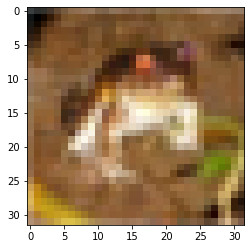

In [21]:
plt.imshow(train_X[0])

In [22]:
train_y[0]

array([6], dtype=uint8)

In [23]:
def define_discriminator():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', input_shape= (32, 32, 3)))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(LeakyReLU(0.2))


  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(lr=0.0002)
  model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics=['accuracy'])

  return model


discr = define_discriminator()
print(discr.summary())



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_2 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [24]:
def define_generator(latent_dim):
  model = Sequential()
  model.add(Dense(8192, input_dim=latent_dim))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((8, 8, 128)))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(3, (8, 8), activation='tanh', padding='same'))

  return model



gen = define_generator(100)
print(gen.summary())




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [25]:
def define_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  opt = Adam(lr=0.0002)
  model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics=['accuracy'])

  return model


In [26]:
def load_real_samples():
  (train_X, _), (_, _) = load_data()
  X = train_X.astype('float32')

  X = (X - 127.5) / 127.5


  return X

In [27]:
def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))

  return X, y

In [28]:
def generate_latent_points(latent_dim, n_samples):
  X_input = randn(latent_dim*n_samples)
  X_input = X_input.reshape(n_samples, latent_dim)

  return X_input

In [29]:
def generate_fake_samples(generator, latent_dim, n_samples):
  X_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(X_input)
  y = zeros((n_samples, 1 ))
  return X, y

In [13]:
def train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=6, n_batch=128 ):
  #bat_per_epo = int(dataset.shape[0] / n_batch)
  bat_per_epo = 1 # for time

  half_batch = int(n_batch / 2)

  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake  = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      print(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss)

  g_model.save('generator_model.h5')

In [30]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=1)
#suggested n_epochs = 20

2/2 [==============================] - 1s 229ms/step
1 1 10 0.7112722396850586 0.7038823962211609 [0.6795756816864014, 1.0]
2/2 [==============================] - 0s 206ms/step
1 2 10 0.30700984597206116 0.7394096851348877 [0.6431695222854614, 1.0]
2/2 [==============================] - 0s 199ms/step
1 3 10 0.16396760940551758 0.8064409494400024 [0.591297447681427, 1.0]
2/2 [==============================] - 0s 194ms/step
1 4 10 0.06833258271217346 0.897255539894104 [0.5429084897041321, 1.0]
2/2 [==============================] - 0s 201ms/step
1 5 10 0.0318620502948761 0.9668558239936829 [0.5228184461593628, 1.0]
2/2 [==============================] - 0s 199ms/step
1 6 10 0.02276396006345749 0.9790860414505005 [0.5492948293685913, 1.0]
2/2 [==============================] - 1s 343ms/step
1 7 10 0.03099735639989376 0.8881734609603882 [0.651157021522522, 1.0]
2/2 [==============================] - 0s 210ms/step
1 8 10 0.04233003407716751 0.7036149501800537 [0.8818050026893616, 0.0]
2/2 [

In [31]:
from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

In [32]:
import keras
g_model = keras.models.load_model('generator_model.h5')



1/1 [==============================] - 0s 239ms/step


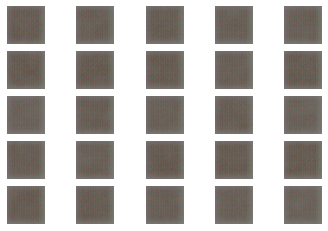

In [33]:
# generate images
latent_points = generate_latent_points(100, 25) 
# generate images
X = g_model.predict(latent_points)

X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)
show_plot(X, 5)
